# Сборный проект №2

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

__Цель проекта__:

Разработать и внедрить модели машинного обучения для предсказания уровня удовлетворённости сотрудников и вероятности их увольнения в компании «Работа с заботой», с целью оптимизации управления персоналом и снижения финансовых потерь, связанных с оттоком сотрудников.

__Задачи проекта__:

1. **Построение модели предсказания уровня удовлетворённости сотрудников**:
   - Разработать модель машинного обучения, способную предсказывать уровень удовлетворённости работой сотрудников на основе предоставленных характеристик и данных. Модель должна учитывать различные факторы, влияющие на удовлетворённость, чтобы обеспечить точные и обоснованные прогнозы.

    
    
2. **Построение модели предсказания вероятности увольнения сотрудников**:
   - Создать модель, которая будет анализировать данные и предсказывать вероятность увольнения сотрудников. Эта модель должна помочь HR-аналитикам выявлять сотрудников, находящихся в группе риска увольнения, и разрабатывать стратегии удержания, предотвращая внезапные увольнения и связанные с ними риски для бизнеса.
    

__План работы:__ 

1. [Импорты и функции для выполнения проекта](#100)    
1. [Загрузка данных](#1)
2. [Предобработка данных](#2)  
3. [Задача № 1](#3)  
    4.1 [Исследовательский анализ](#3.1)      
    4.2 [Корреляционный анализ](#3.2)     
    4.3 [Подготовка данных](#3.3)     
    4.4 [Подготовка пайплайна](#3.4)     
    4.5 [Подбор гиперпараметров и лучшей модели](#3.5)      
    4.5 [Применение модели на тестовой выборке](#3.6)      
    4.5 [Итог задания №1](#3.7)        
3. [Задача № 2](#4)  
    5.1 [Исследовательский анализ](#4.1)          
    5.2 [Подготовка данных](#4.3)     
    5.3 [Подготовка пайплайна](#4.4)     
    5.4 [Подбор гиперпараметров](#4.5)     
    5.5 [Применение модели на тестовой выборке](#4.6)     
    5.6 [Итог задания №2](#4.7)       
8. [Итоговый вывод](#8)


## Импорты и функции для выполнения проекта <a id=100 >

In [1]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Импортируем необходимые библиотеки для работы 
import pandas as pd
from math import *
import numpy as np
from scipy import stats as st
# Метрики и оОбработка данных
from sklearn.metrics import (make_scorer, f1_score, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder,
    OrdinalEncoder, MinMaxScaler,
    LabelEncoder, PolynomialFeatures
)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

# Графическое отображение
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

# Модели обучения
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings("ignore") #импортировал после завершения проекта, для удобного код-ревью

#Зададим константы
TEST_SIZE = 0.25
RANDOM_STATE = 42
COUNT=50

In [5]:
# Функция для отображения информации о датасете
def show_info(df):
    print('Количество строк выборки составляет:',df.shape[0],'\n')
    display('Первые пять строк', df.head())
    print('Общая информация о данных\n')
    print(df.info())
    display('Описание',df.describe().T)
    print('Количество явных дубликатов составляет',df.duplicated().sum())


In [6]:
#Функция для отображения уникальных значений в категориальных данных для поиска неявных дубликатов
def category_hide_duplicates(df):
    cat_col_names = df.select_dtypes(include='object').columns.tolist()
    for col in cat_col_names:
        print(col,':')
        print(df[col].unique())
        print('==================================')
    

In [7]:
#Функция отображения гистограм и боксплотов для исследовательского анализа
def search_plot(df_col, title_name, bins):

    mean = df_col.mean()
    median = df_col.median()
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f"{title_name}", fontsize=13)
    
    sns.histplot(df_col, bins=bins, kde=True, ax=ax[0])
    ax[0].set_title('Гистограмма', fontsize=10)
    ax[0].set_xlabel(title_name)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)
    
    ax[0].axvline(mean, color='red', linestyle='--', label=f'Среднее = {mean:.2f}')
    ax[0].axvline(median, color='purple', linestyle='-.', label=f'Медиана = {median:.2f}')
    ax[0].legend()

    sns.boxplot(x=df_col, ax=ax[1], color='pink')
    ax[1].set_title('Диаграмма размаха', fontsize=10)
    ax[1].axvline(median, color='green', linestyle='-.')
    ax[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    
    display(df_col.describe().T)
    print('')
    
    stat, p = st.shapiro(df_col)
    alpha = 0.1  # Уровень значимости
    if p > alpha:
        print("По тесту Шапиро-Уилка: Распределение похоже на нормальное")
    else:
        print("По тесту Шапиро-Уилка: Распределение отличается от нормального")

In [8]:
    def search_сategory(df,col):

        ratio = round(df.groupby(col)[col].count()/df[col].count()*100)

        ratio.plot(
        kind = 'pie',
        autopct='%1.1f%%',
        labels = ratio.index,
        figsize=(6,6),
        title = 'Круговая диаграмма соотношения признаков в данных '+ col,
        ylabel = '',
        fontsize = 12
        )
        display(ratio)

In [9]:
def short_search_plot(df_col, title_name, bins):

    mean = df_col.mean()
    median = df_col.median()
    
    plt.figure(figsize=(12, 8))
    
    fig = sns.histplot(df_col, bins=bins, kde=True)
    fig.set_title('Гистограмма', fontsize=10)
    fig.set_xlabel(title_name)
    fig.set_ylabel('Частота')
    fig.grid(True)
    
    fig.axvline(mean, color='red', linestyle='--', label=f'Среднее = {mean:.2f}')
    fig.axvline(median, color='purple', linestyle='-.', label=f'Медиана = {median:.2f}')
    fig.legend()

    plt.show()

In [10]:
def discrete_search_plot(df_col, title_name):

    plt.figure(figsize=(12, 8))
    sns.color_palette("crest", as_cmap=True)
    
    fig = sns.countplot(df_col, x = title_name, edgecolor='black')
    fig.set_title(title_name, fontsize=14)
    fig.set_xlabel(title_name)
    fig.set_ylabel('Количество')
    fig.grid(True)



    plt.show()

In [11]:
def ScatterShow(df, name_of_feature):
    ### Создадим список  признаков 
    col = ['level','workload','salary','dept', 'employment_years', 'supervisor_evaluation']

    # Построение диаграмм рассеяния
    plt.figure(figsize=(15, 20))

    for i, k in enumerate(col, 1):
        plt.subplot(3, 2, i)
        sns.scatterplot(
            data=df,
            x=k,
            y='job_satisfaction_rate',
            hue = name_of_feature,
            alpha=0.7
        )
        plt.title(f'Уволенные сотрудники, {k}')

    plt.show()

## Загрузка данных <a id='1'>

In [12]:
try:
    df_main_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep =',')
    df_features = pd.read_csv('/datasets/test_features.csv', sep =',')
    df_main_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep =',')
    df_add_train = pd.read_csv('/datasets/train_quit.csv')
#    df_add_features = pd.read_csv('/datasets/test_features.csv') #используются те же входные признаки, что и в df_fetures
    df_add_target = pd.read_csv('/datasets/test_target_quit.csv')
except:
    df_main_train = pd.read_csv('train_job_satisfaction_rate.csv', sep =',')
    df_features = pd.read_csv('test_features.csv', sep =',')
    df_main_target = pd.read_csv('test_target_job_satisfaction_rate.csv', sep =',')
    df_add_train = pd.read_csv('train_quit.csv')
#    df_add_features = pd.read_csv('test_features.csv')
    df_add_target = pd.read_csv('test_target_quit.csv')

    
df_list=[
     df_main_train,
     df_features,
     df_main_target,
     df_add_train,
     df_add_target
]


Для этой задачи заказчик предоставил данные с признаками:

- **id** — уникальный идентификатор сотрудника;
- **dept** — отдел, в котором работает сотрудник;
- **level** — уровень занимаемой должности;
- **workload** — уровень загруженности сотрудника;
- **employment_years** — длительность работы в компании (в годах);
- **last_year_promo** — показывает, было ли повышение за последний год;
- **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
- **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
- **salary** — ежемесячная зарплата сотрудника;
- **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [13]:
i=1
for df in df_list:
    print(f'------------ ДАТАСЕТ №{i} ------------')
    show_info(df)
    print(f'\n------------------------------------')
    i+=1

------------ ДАТАСЕТ №1 ------------
Количество строк выборки составляет: 4000 



'Первые пять строк'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


Количество явных дубликатов составляет 0

------------------------------------
------------ ДАТАСЕТ №2 ------------
Количество строк выборки составляет: 2000 



'Первые пять строк'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


Количество явных дубликатов составляет 0

------------------------------------
------------ ДАТАСЕТ №3 ------------
Количество строк выборки составляет: 2000 



'Первые пять строк'

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.21350,253851.326129,100298.00,339052.00,550793.00,765763.75,999029.0
job_satisfaction_rate,2000.0,0.54878,0.220110,0.03,0.38,0.58,0.72,1.0


Количество явных дубликатов составляет 0

------------------------------------
------------ ДАТАСЕТ №4 ------------
Количество строк выборки составляет: 4000 



'Первые пять строк'

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
id,4000.0,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
employment_years,4000.0,3.70150,2.541852,1.0,2.00,3.0,6.00,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.00,4.0,4.00,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.00,30000.0,43200.00,96000.0


Количество явных дубликатов составляет 0

------------------------------------
------------ ДАТАСЕТ №5 ------------
Количество строк выборки составляет: 2000 



'Первые пять строк'

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


'Описание'

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0


Количество явных дубликатов составляет 0

------------------------------------


__Датасет № 1__:

- Обнаружены пропуски в колонках _dept_ и _level_

__Датасет № 2__:

- Обнаружены пропуски в колонках _dept_ и _level_


__По остальным данным__ замечаний нет, признаки совпадают с описанием.

__Общие наблюдения__ (describe):
- Большинство сотрудников имеют стаж работы от 1 до 10 лет, с преобладанием 3-4 лет.
- Оценки работы сотрудников в целом находятся на уровне выше среднего, однако есть значительное количество сотрудников с низкими оценками.
- Средняя зарплата сотрудников составляет около 33926.70, с заметным разбросом, что может указывать на различия в должностях или уровнях ответственности.
- Тренировочные и тестовые данные схожи: редние значения близки, с небольшим отличием.

In [14]:
#Создадим переменную в которой будет хранится значение количества исходных сырых данных
raw_data_count_1 = df_main_train.shape[0]
raw_data_count_2 = df_add_train.shape[0]

### Итог по загрузке данных

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

1. Обнаружены пропуски в первом и втором датафрейме.
    
    
2. Сотрудники имеют стаж работы преимущественно от 1 до 10 лет, с оценками выше среднего и средней зарплатой около 33926.70, но с заметным разбросом, что может указывать на различия в должностях или уровнях ответственности.

## Предобработка данных <a id='2'>

### Обработка пропусков

Посмотрим количество пропусков

In [15]:
df_main_train[df_main_train. isna(). any(axis=1)]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Всего в сумме 10 пропусков из датасета. Оставим пайплану разобраться с ними

In [16]:
df_features.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Всего в сумме 3 пропуска из датасета. Оставим пайплану разобраться с ними

### Проверка неявных дубликатов

In [17]:
category_hide_duplicates(df_main_train)

dept :
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level :
['junior' 'middle' 'sinior' nan]
workload :
['medium' 'high' 'low']
last_year_promo :
['no' 'yes']
last_year_violations :
['no' 'yes']


__Неявные дубликаты__ отсутствуют

-----


In [18]:
category_hide_duplicates(df_features)

dept :
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level :
['junior' 'middle' 'sinior' nan]
workload :
['medium' 'low' 'high' ' ']
last_year_promo :
['no' 'yes']
last_year_violations :
['no' 'yes']


Обнаружен пробел. Взглянем на такие данные:

In [19]:
df_features['dept'].value_counts().sort_values(ascending=False)

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

In [20]:
df_features['workload'].value_counts().sort_values(ascending=False)

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

Всего обнаружено 2 строки с пробелами. Заменим самыми встречающимися категориями.

In [21]:
df_features['dept'] = df_features['dept'].replace(' ', np.NaN)
df_features['workload'] = df_features['workload'].replace(' ', np.NaN)

In [22]:
category_hide_duplicates(df_features)

dept :
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
level :
['junior' 'middle' 'sinior' nan]
workload :
['medium' 'low' 'high' nan]
last_year_promo :
['no' 'yes']
last_year_violations :
['no' 'yes']


__Пробелы заменены на Nan__ которые в последствии обработает пайплан


-----


In [23]:
category_hide_duplicates(df_add_train)

dept :
['sales' 'purchasing' 'marketing' 'technology' 'hr']
level :
['middle' 'junior' 'sinior']
workload :
['high' 'medium' 'low']
last_year_promo :
['no' 'yes']
last_year_violations :
['no' 'yes']
quit :
['no' 'yes']


__Неявные дубликаты__ отсутствуют

-----


In [24]:
category_hide_duplicates(df_add_target)

quit :
['yes' 'no']


__Неявные дубликаты__ отсутствуют

-----


### Итог предобработки данных

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

1. Устранены пропуски в 1-м и 2-м датафрейме.
    
2. Обнаружены и устранены 'пробелы' в категориальных данных
    
~~3. Выровняли соотношение входных и целевых признаков, после обработки данных~~  
    
После корректировок замечаний к данным нет.

## Задача №1 <a id='3'>

### Исследовательский анализ данных <a id='3.1'>

#### Количественные переменные

##### salary

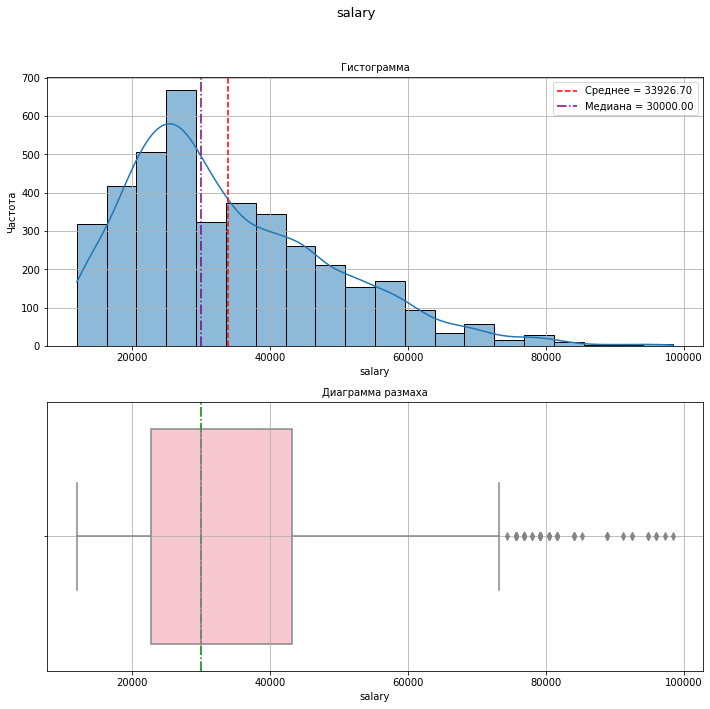

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [25]:
search_plot(df_main_train['salary'],'salary', bins = 20)

- Распределение похоже на распределение Пуассонва.   
- Выбросы не являются аномальными и удалять их не будем.    
- Среднее значение смещено в большую сторону. 

-----

##### employment_years

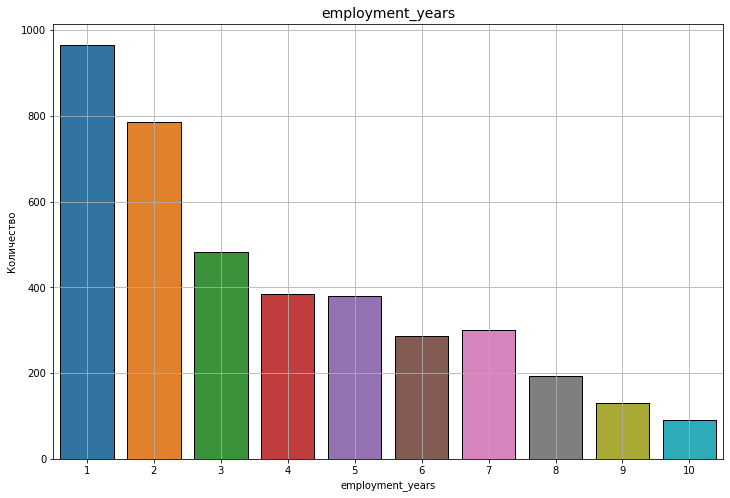

In [26]:
discrete_search_plot(df_main_train['employment_years'],'employment_years')

- Наибольшее количество людей (около 950) имеет стаж работы **от 1 года до 2 лет**. 
- С увеличением стажа работы количество людей уменьшается.
- Наименьшее количество людей (около 100) имеет стаж работы **10 лет**. 

____

##### supervisor_evaluation

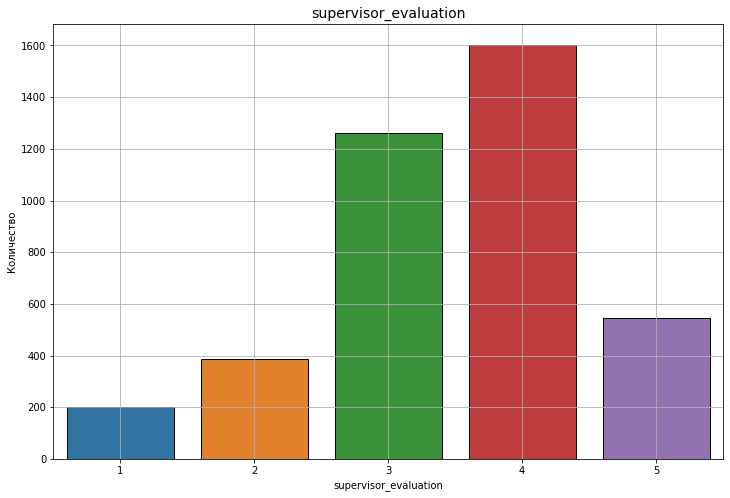

In [27]:
discrete_search_plot(df_main_train['supervisor_evaluation'],'supervisor_evaluation')

- Большинство сотрудников получили оценки 3 и 4.
- Меньше всего сотрудников получили оценку 1.
- Наблюдается некоторая тенденция к более высоким оценкам, с пиком в оценке 4.

____

##### job_satisfaction_rate

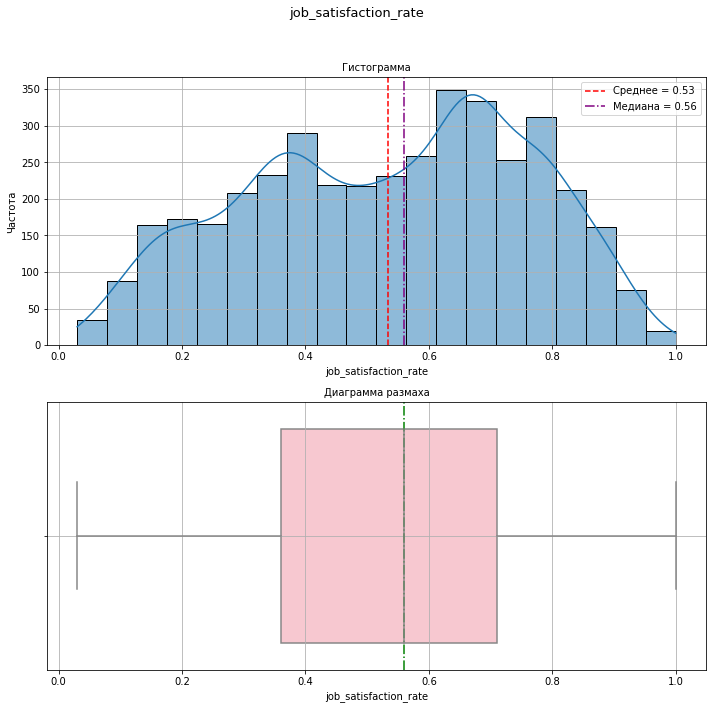

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [28]:
search_plot(df_main_train['job_satisfaction_rate'],'job_satisfaction_rate', bins = 20)

- Уровень удовлетворенности работой сотрудников в целом достаточно высокий.
- Есть небольшое количество сотрудников с очень низким уровнем удовлетворенности работой.
- Достаточно высокая дисперсия


#### Категориальные переменные

##### dept

dept
hr            11.0
marketing     14.0
purchasing    15.0
sales         38.0
technology    22.0
Name: dept, dtype: float64

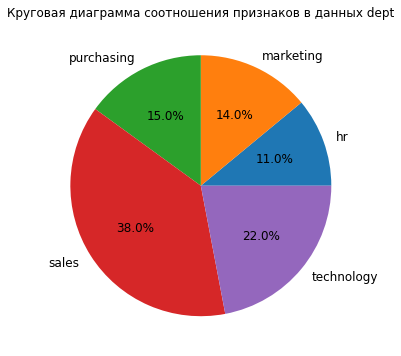

In [29]:
search_сategory(df_main_train,'dept')

- Наблюдается дисбаланс классов. Мажорный класс `sales`

_____

##### level

level
junior    47.0
middle    44.0
sinior     9.0
Name: level, dtype: float64

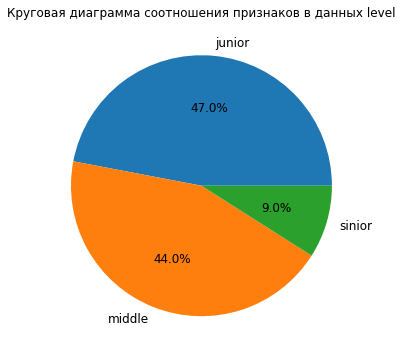

In [30]:
search_сategory(df_main_train,'level')

- Наблюдается дисбаланс классов. Мажорный класс `junior`
_____

##### last_year_promo

last_year_promo
no     97.0
yes     3.0
Name: last_year_promo, dtype: float64

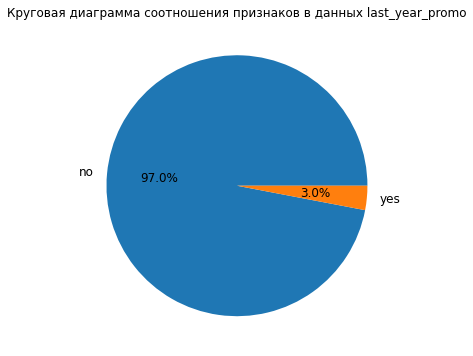

In [31]:
search_сategory(df_main_train,'last_year_promo')

- Наблюдается сильнейший дисбаланс классов, мажорный класс `no`
- Почти никто из сотрудников не получал повышение, только единицы
- Возможно придется отказаться от этого признака при обучении модели

_____

##### last_year_violations

last_year_violations
no     86.0
yes    14.0
Name: last_year_violations, dtype: float64

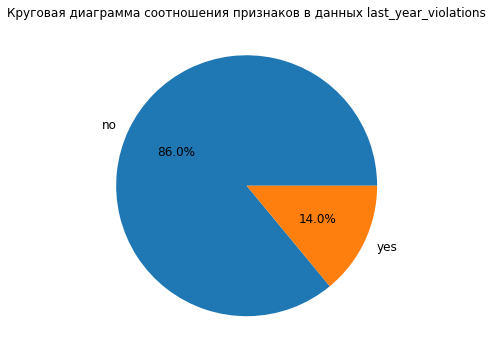

In [32]:
search_сategory(df_main_train,'last_year_violations')

- Наблюдается дисбаланс классов. Мажорный класс `no`
- Большинство сотрудников не нарушает правила

_____

#### Целевые признаки

##### job_satisfaction_rate

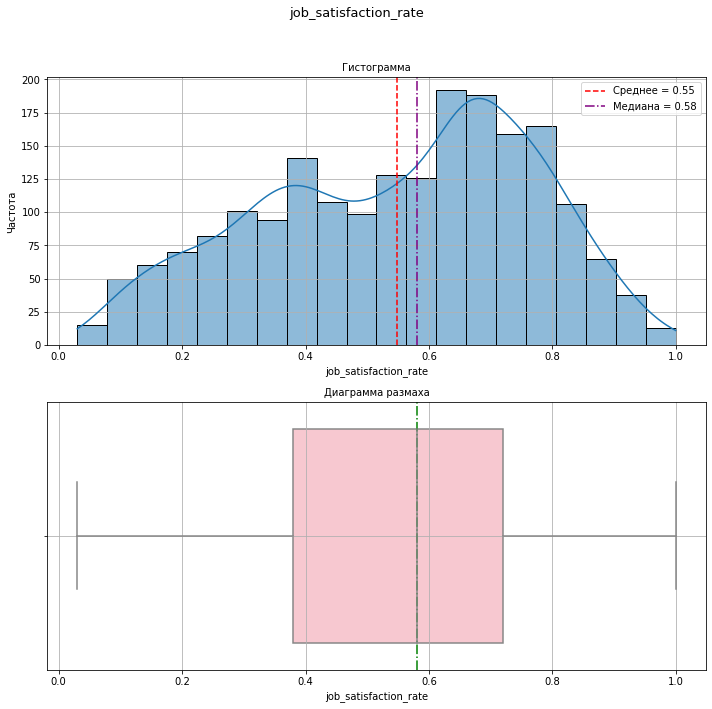

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [33]:
search_plot(df_main_target['job_satisfaction_rate'],'job_satisfaction_rate', bins = 20)

Распределение в целевом таргете практически совпадает с распределением в тренировочной выборке
_____

### Итог по исследовательскому анализу

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

Был проведен исследовательский анализ данных и сформулированы следующие выводы:

* Количественные признаки не имеют нормального распределения, в доходах присутсвуют выбросы но не аномальные. Также встречаются признаки с распределением Пуассона.
    
* Категориальные данные показывают дисбаланс классов, что требует внимания при дальнейшей работе.

### Корреляционный анализ <a id='3.2'>

> Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. 

    так как не все данные имеют нормальное распределение, то будем пользоваться методом Phik, который более устойчив     
    к ненормальному распределению, а также посмотреть корреляцию в категориальных данных.

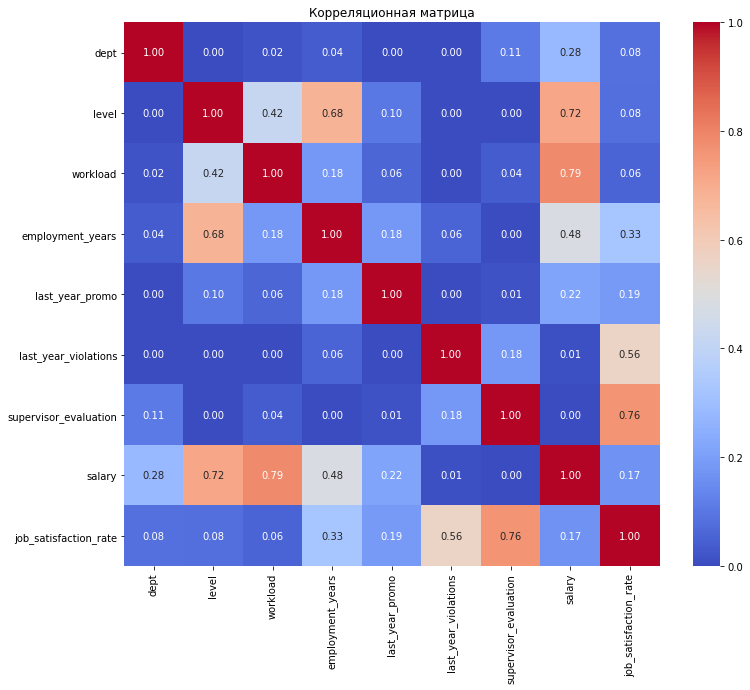

In [34]:
# Отберем столбцы с количественными данными и удалим дискретные признаки
num_col = df_main_train.select_dtypes(include = 'number').columns.drop('supervisor_evaluation', 'employment_years')

# Сделаем id индексом
df_main_train = df_main_train.set_index('id')

phik_matrix = df_main_train.phik_matrix(interval_cols=num_col)

plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

По матрице корреляции можно сделать следующие выводы:    
     
1. наблюдается умеренная корееляция входных признаков загруженности и зарплаты,  мультиколлинеарности не наблюдаем.    
2. наиболее коррелируемые признаки с целевым это:
    - оценка работодателя    
    - повышение в последнем году
    - небольшая корреляция со стажем
3. Зарплата коррелирует с уровнем и загруженностью.

#### Итог по корреляционному анализу

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

Был проведен корреляционный анализ данных.
    
* Мультиколлинеарность входных признаков отсутсвует.
    
* Обнаружены признаки, которые коррелируют с целевым.
    
* Мало признаков которые сильно коррелируют с целевым таргетом

### Подготовка данных <a id='3.2'>

__Перед началом обучения модели, проверим размерности тестовой и тренировочной выборки.__

In [35]:
print('размер выборки(строк, столбцов):', df_main_train.shape)
df_main_train.head(1)

размер выборки(строк, столбцов): (4000, 9)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58


In [36]:
#сделаем id индексом
df_features = df_features.set_index('id')

print('размер выборки(строк, столбцов):', df_features.shape)
df_features.head(1)

размер выборки(строк, столбцов): (2000, 8)


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800


Отлично, можно выделять целевой таргет

-----

#### Разделение тренировочной и валидационной выборки

In [37]:
    X_train = df_main_train.drop(['job_satisfaction_rate'], axis=1)
    y_train = df_main_train['job_satisfaction_rate']

In [38]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X,
#     y,
#     test_size = TEST_SIZE, 
#     random_state = RANDOM_STATE
# )

In [39]:
print('Размер тренировочной выборки:', X_train.shape)
print('Размер выборки для целевых признаков тренировочной выборки:', y_train.shape[0])

Размер тренировочной выборки: (4000, 8)
Размер выборки для целевых признаков тренировочной выборки: 4000


#### Выделение num, ohe и ord столбцов

Признак `level` и `workload` относится к ранговым признакам и будут кодироваться с помощью _OrdinalEncoder_

In [40]:
num_columns = X_train.select_dtypes(include='number').columns.tolist()
ohe_columns = X_train.select_dtypes(include='object').drop(['level', 'workload'], axis=1).columns.tolist()
ord_columns = ['level', 'workload']

In [41]:
print(
    ' Числовые признаки:',num_columns,'\n',
    'Категориальные OHE:',ohe_columns,'\n',
    'Категориальные ORD:',ord_columns
)

 Числовые признаки: ['employment_years', 'supervisor_evaluation', 'salary'] 
 Категориальные OHE: ['dept', 'last_year_promo', 'last_year_violations'] 
 Категориальные ORD: ['level', 'workload']


-----

### Метрика SMAPE <a id='3.1'>

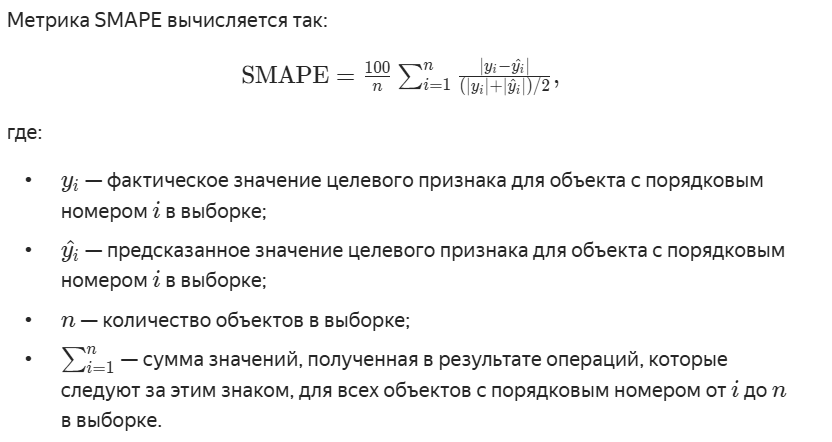 

In [42]:
# Создаем новую метрику SMAPE
def smape(y_true, y_pred):
    
    up = np.abs(y_pred - y_true)
    down = (np.abs(y_true) + np.abs(y_pred)) / 2
    res = np.divide(up, down, out=np.zeros_like(up), where=down != 0)
    return np.mean(res) * (100)


# Создаём пользовательскую метрику
smape_score = make_scorer(smape, greater_is_better=False)

------

### Подготовка Пайплайна <a id='3.4'>

In [43]:
ohe_pipe = Pipeline(
    [
        (
            'SimpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output=False)
        )
    ]
)


In [44]:
ord_pipe = Pipeline(
    [
        (
            'SimpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle','sinior'],
                    ['low','medium','high'],
                ],
                handle_unknown='use_encoded_value',unknown_value=np.nan
            )
        ),
        (
            'SimpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [45]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns),
        ], remainder='passthrough'
)

In [46]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [47]:
param_grid_first = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()]
    },
    {
        'models': [SVR()],
        'models__kernel': ['rbf', 'poly', 'sigmoid'],
        'models__degree' : range(2,5),
    }
]

### Подбор гиперпараметрови и лучшей модели <a id='3.5'>

In [48]:
# Инициализируем переменную для автоматизированного поиска гиперпараметров

gs = GridSearchCV(
    pipe_final, 
    param_grid_first, 
    cv=5,
    scoring=smape_score,
    n_jobs=-1
)

In [49]:
%%time
gs.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', gs.best_estimator_)
print ('Метрика лучшей модели на кросс валидации:', gs.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

1) При подборе гиперпараметров методом GridSearchCV обнаружена лучшая модель SVR(degree = 2) c метрикой smape = 14.7 на кросс-валидации.    

#### Анализ важности признаков

In [50]:
# Извлечение лучшей модели из результата
best_model = gs.best_estimator_.named_steps['models']

# Предобработка данных через пайплайн без конечной модели
preprocessor = gs.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(X_train)
#X_test_preprocessed = preprocessor.transform(X_test)

# Получаем имена признаков после OneHotEncoder
ohe_feature_names = (
    preprocessor
    .named_transformers_['ohe']
    .named_steps['ohe']
    .get_feature_names_out(input_features=ohe_columns)
)

ord_feature_names = ord_columns
num_feature_names = num_columns

# Объединяем все имена признаков в один список
all_feature_names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])

# Создаем единый датафрейм
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
#X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Семпл данных для KernelExplainer
X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df, COUNT, random_state=RANDOM_STATE)
#X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df, COUNT, random_state=RANDOM_STATE)


In [51]:
explainer = shap.KernelExplainer(best_model.predict, X_train_preprocessed_smpl)
shap_values = explainer.shap_values(X_train_preprocessed_smpl)

# Построение графика с именами признаков
#shap.summary_plot(shap_values, X_test_preprocessed_smpl, max_display=10)

  0%|          | 0/50 [00:00<?, ?it/s]

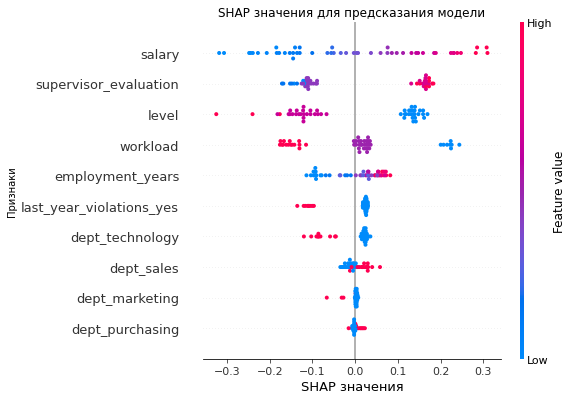

In [52]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_preprocessed_smpl, max_display=10, show=False)
plt.title('SHAP значения для предсказания модели')
plt.ylabel('Признаки')
plt.xlabel('SHAP значения')
plt.show()

Самыми влиятельными признками оказались:
1.  Оценка руководителя -- чем выше руководитель оценивает работу сотрудника (и наоборот), тем выше(ниже) удовлетворенность сотрудника
2. Высокая зарпалата улучшает удовлетворенность, но низкая зарплата влияет сильнее на снижение удовлетворенности.
3. Высокая загруженность уменьшает удовлетворенность, низкая и средняя улучшает, но средняя загруженность влияет незначительно.
4. Чем меньше стаж сотрудника в компании, тем меньше его удовлетворенность.
5. Отдел технологий - отдел в котором наблюдается неудовлетворенность
6. Повышение на работе увеличивает удовлетворенность

### Применение модели на тестовой выборке <a id='3.6'>

In [53]:
# Сортируем входные признаки по индексам для предотвращения неверной оценки
df_features = df_features.sort_index()

In [54]:
df_features.head()


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [55]:
# Сортируем таргет по индексам для предотвращения неверной оценки
df_main_target = df_main_target.sort_values(by='id').set_index('id')

In [56]:
df_main_target.head()

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


In [57]:
# Предобработка данных через пайплайн без конечной модели
preprocessor = gs.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(df_features)

pred_test = best_model.predict(X_train_preprocessed)

In [58]:
smape_result = smape(df_main_target['job_satisfaction_rate'], pred_test)

print(f'Метрика SMAPE на тестовой выборке: {round(smape_result,2)}')

Метрика SMAPE на тестовой выборке: 13.74


In [59]:
# Добавим новый предсказанный признак
df_features['job_satisfaction_rate'] = pred_test
df_features.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.839583


### Итог задания № 1 <a id='3.7'>

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">
    
**Обучение модели**:

* Была проведена подготовка тренировочной и валидационной выборки. Также закодирован целевой признак методом _LabelEncoder_
    
* Создан единый пайплан, который содержит в себе масштабирование входных признаков и 3 модели.
    
* Использован подбор гиперпараметров _GridSearchCV_ 
    
* Лучшая модель -- **SVR** с метрикой __smape = 13.74__ на тестовой выборке
    
**Анализ важности**   
    
1. Была выделена лучшая модель и построен график важности с помощью метода SHAP.
2. Самыми влиятельными признками оказались: __Оценка руководителя__, __зарпалата__ и __загруженность__

## Задача №2 <a id='4'>

Загрузка и обработка данных была выполнена совместно с данными из первой задачи.
Сейчас проведем исследовательский анализ.

### Исследовательский анализ <a id='4.1'>

#### Количественные переменные

##### salary

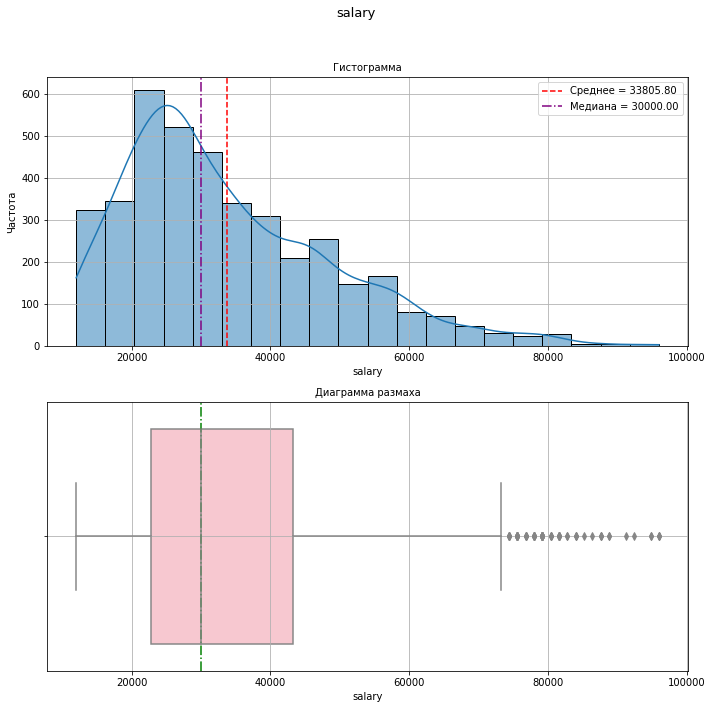

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [60]:
search_plot(df_add_train['salary'],'salary', bins = 20)

- Распределение похоже на распределение Пуассонва.   
- Выбросы не являются аномальными и удалять их не будем.    
- Среднее значение смещено в большую сторону. 

-----

##### employment_years

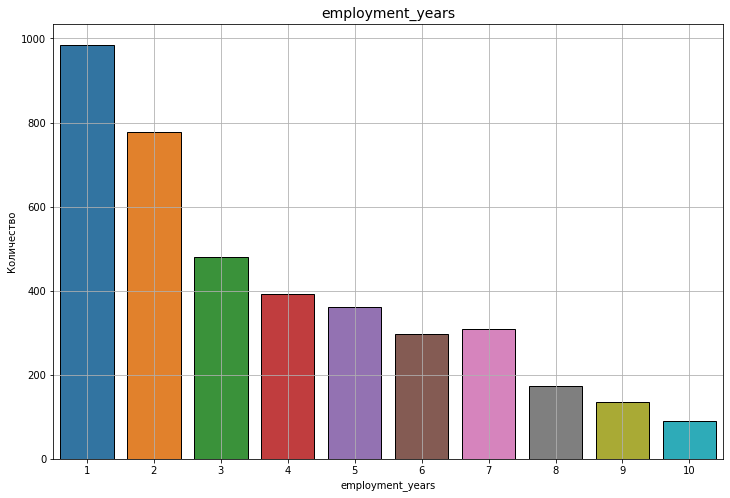

In [61]:
discrete_search_plot(df_add_train['employment_years'],'employment_years')

- Наибольшее количество людей (около 950) имеет стаж работы **от 1 года до 2 лет**. 
- С увеличением стажа работы количество людей уменьшается.
- Наименьшее количество людей (около 100) имеет стаж работы **10 лет**. 

____

##### supervisor_evaluation

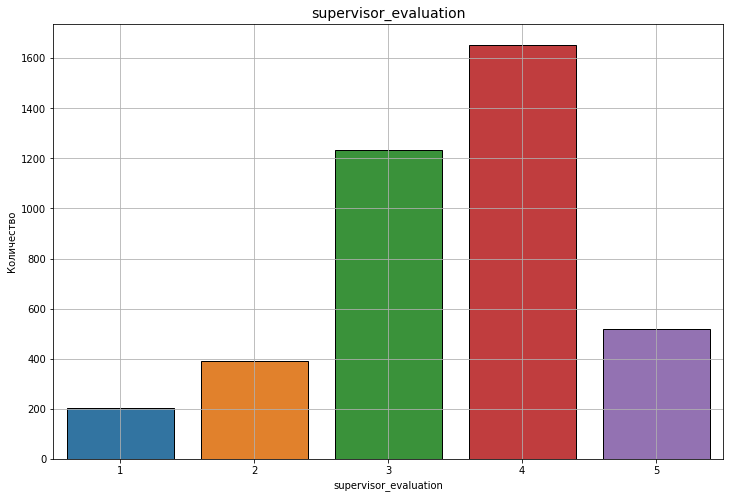

In [62]:
discrete_search_plot(df_add_train['supervisor_evaluation'],'supervisor_evaluation')

- Большинство сотрудников получили оценки 3 и 4.
- Меньше всего сотрудников получили оценку 1.
- Наблюдается некоторая тенденция к более высоким оценкам, с пиком в оценке 4.

____

#### Категориальные переменные

##### dept

dept
hr            12.0
marketing     15.0
purchasing    15.0
sales         36.0
technology    23.0
Name: dept, dtype: float64

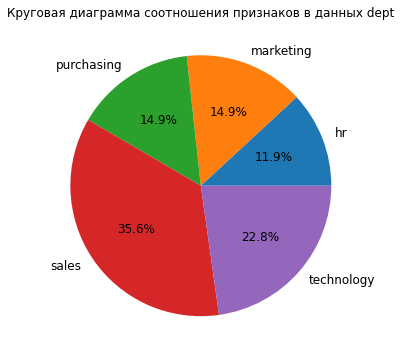

In [63]:
search_сategory(df_add_train,'dept')

- Наблюдается дисбаланс классов. Мажорный класс `sales`

_____

##### level

level
junior    49.0
middle    42.0
sinior     9.0
Name: level, dtype: float64

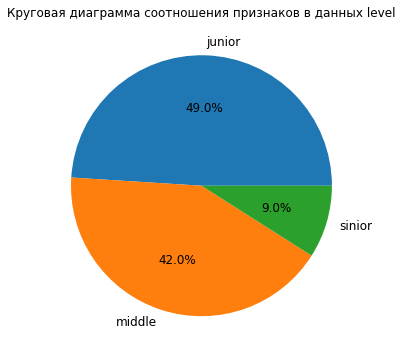

In [64]:
search_сategory(df_add_train,'level')

- Наблюдается дисбаланс классов. Мажорный класс `junior`
_____

##### last_year_promo

last_year_promo
no     97.0
yes     3.0
Name: last_year_promo, dtype: float64

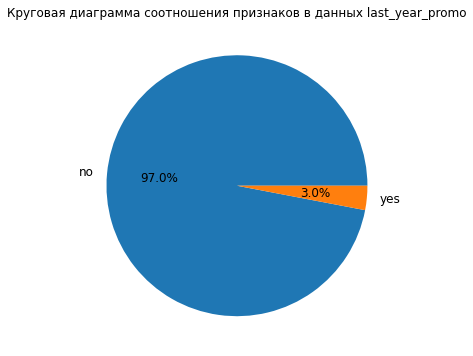

In [65]:
search_сategory(df_add_train,'last_year_promo')

- Наблюдается сильнейший дисбаланс классов, мажорный класс `no`
- Почти никто из сотрудников не получал повышение, только единицы
- Возможно придется отказаться от этого признака при обучении модели

_____

##### last_year_violations

last_year_violations
no     86.0
yes    14.0
Name: last_year_violations, dtype: float64

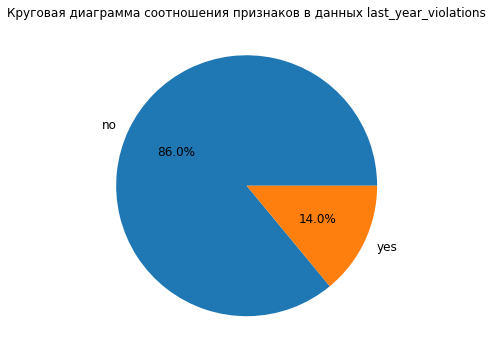

In [66]:
search_сategory(df_add_train,'last_year_violations')

- Наблюдается дисбаланс классов. Мажорный класс `no`
- Большинство сотрудников не нарушает правила

_____

#### Целевые признаки

##### quit

quit
no     72.0
yes    28.0
Name: quit, dtype: float64

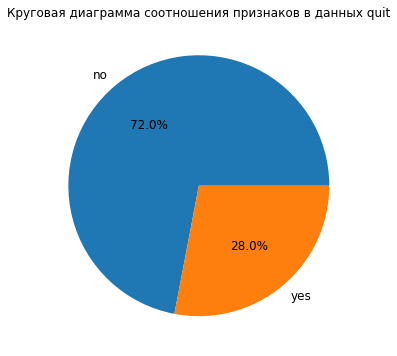

In [67]:
search_сategory(df_add_target,'quit')

- Наблюдается дисбаланс классов, необходимо использовать эту информацию при обучении.
- Почти треть сотрудников собираются уйти из компании. 

____

#### Добавление признака удовлетворенности

##### Корреляция ухода работника из компании и его удовлетворенностью

Для того чтобы добавить новый признак, получим данные с помощью лучшей модели машинного обучения из первого задания. Предварительно уберем целевой признак.

In [68]:
#Сделаем индексацию по id
df_add_train = df_add_train.set_index('id')

In [69]:
X = df_add_train.drop(['quit'], axis=1)
y = df_add_train['quit']

In [70]:
predict_feature = gs.best_estimator_.predict(X)

In [71]:
predict_feature

array([0.57676177, 0.8277655 , 0.32278173, ..., 0.45660534, 0.49984045,
       0.53305973])

In [72]:
# Добавим новый признак из модели
X['job_satisfaction_rate']=predict_feature
X.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.576762


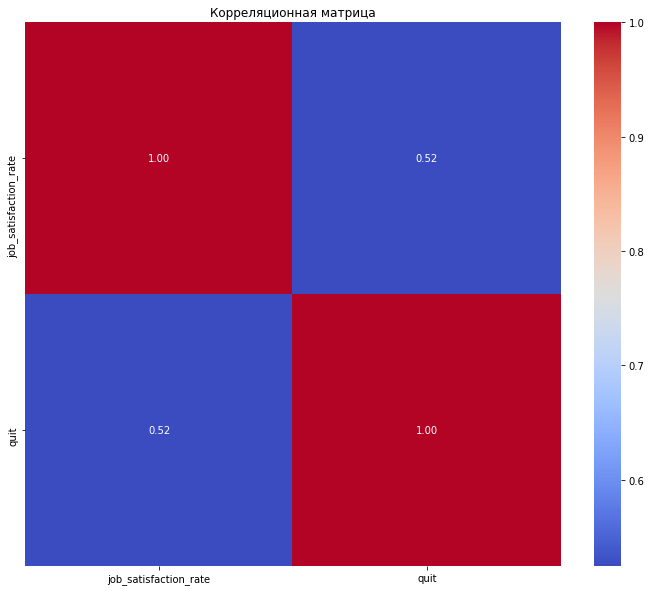

In [73]:
# Сделаем полный датасет с входными и целевым признаком для составлении матрицы корреляции

data_for_analize = pd.merge(X,y,left_index=True, right_index = True)
data_for_corr = data_for_analize[['job_satisfaction_rate', 'quit']]
# Отберем столбцы с количественными данными
num_col = data_for_corr.select_dtypes(include = 'number').columns

phik_matrix_2 = data_for_corr.phik_matrix(interval_cols=num_col)

plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix_2, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

Можно сделать вывод в том, что корреляция между уволившимся работником и его удовлетворенность существует.     
А значит предположение аналитиков верно: уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник или нет. 

##### Портрет уволившегося сотрудника


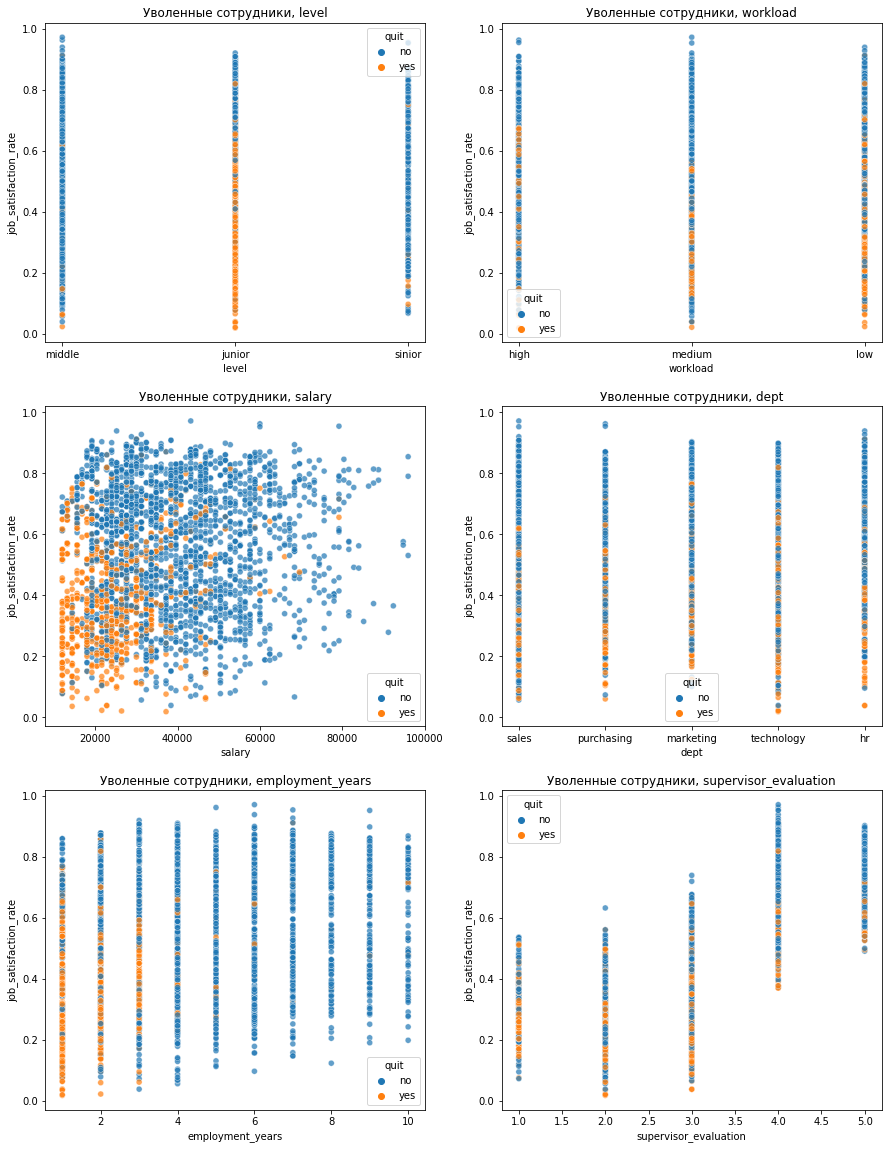

In [74]:
ScatterShow(data_for_analize,'quit')

In [75]:
pivot = data_for_analize.pivot_table(
    index = 'dept',
    columns = 'quit',
    values = 'level',
    aggfunc = 'count'    
).reset_index()

In [76]:
fired_proportion = round(pivot['yes']/pivot['no'],2)
pivot['fired_proportion'] = fired_proportion
pivot

quit,dept,no,yes,fired_proportion
0,hr,348,116,0.33
1,marketing,419,163,0.39
2,purchasing,422,166,0.39
3,sales,1031,407,0.39
4,technology,652,276,0.42


**Портрет уволившегося сотрудника**:

- Скорее всего работает в отделе продаж и технологий
- Имеет низшую должность (junior)
- Имеет низкую / среднюю загруженность
- В среднем проработал 1-2 года в компании
- В среднем зарабатывает до 30'000 
- Оценка работодателя меньше 4

#### Итог по исследовательскому анализу

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">

1. Новые данные схожи с теми, что были даны в первом задании
    
    
2. Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник или нет
    
    
3. Составлен портрет уволившегося сотрудника:
    - Скорее всего работает в отделе продаж и технологий
    - Имеет низшую должность (junior)
    - Имеет низкую / среднюю загруженность
    - В среднем проработал 1-2 года в компании
    - В среднем зарабатывает до 30'000 
    - Оценка работодателя меньше 4
    

4. Из каждого отдела уходит от 33% до 42% сотрудников

### Подготовка данных <a id='4.3'>

In [77]:
# Добавим labelEncoder для кодирования целевого признака quit в Тренировочной выборке
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [78]:
X_train_2, y_train_2 = X, y

In [79]:
print('Размер тренировочной выборки:', X_train_2.shape)
print('Размер выборки для целевых признаков тренировочной выборки:', y_train_2.shape[0])

Размер тренировочной выборки: (4000, 9)
Размер выборки для целевых признаков тренировочной выборки: 4000


In [80]:
num_columns = X_train_2.select_dtypes(include='number').columns.tolist()
ohe_columns = X_train_2.select_dtypes(include='object').drop(['level', 'workload'], axis=1).columns.tolist()
ord_columns = ['level', 'workload']

### Подготовка   пайплана <a id='4.4'>

In [81]:
param_grid_second = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5)
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 100)
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression()],
        'models__C': range(1, 5)
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'rbf']
    }
]

### Подбор гиперпараметров <a id='4.4'>

In [82]:
gs_2 = GridSearchCV(
    pipe_final, 
    param_grid_second, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [83]:
%%time
gs_2.fit(X_train_2, y_train_2)

print('Лучшая модель и её параметры:\n\n', gs_2.best_estimator_)
print ('Метрика лучшей модели на кросс валидации:', gs_2.best_score_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

### Анализ важности признаков <a id='4.0'>

In [84]:
# Извлечение лучшей модели из результата
best_model = gs_2.best_estimator_.named_steps['models']

# Предобработка данных через пайплайн без конечной модели
preprocessor = gs_2.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(X_train_2)
#X_test_preprocessed = preprocessor.transform(X_test_2)

# Получаем имена признаков после OneHotEncoder
ohe_feature_names = (
    preprocessor
    .named_transformers_['ohe']
    .named_steps['ohe']
    .get_feature_names_out(input_features=ohe_columns)
)

ord_feature_names = ord_columns
num_feature_names = num_columns

# Объединяем все имена признаков в один список
all_feature_names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])

# Создаем единый датафрейм
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
#X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Семпл данных для KernelExplainer
X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df, COUNT, random_state=RANDOM_STATE)
#X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df, COUNT, random_state=RANDOM_STATE)


In [85]:
explainer = shap.KernelExplainer(best_model.predict, X_train_preprocessed_smpl)
shap_values = explainer.shap_values(X_train_preprocessed_smpl)

# Построение графика с именами признаков
#shap.summary_plot(shap_values, X_test_preprocessed_smpl, max_display=10)

  0%|          | 0/50 [00:00<?, ?it/s]

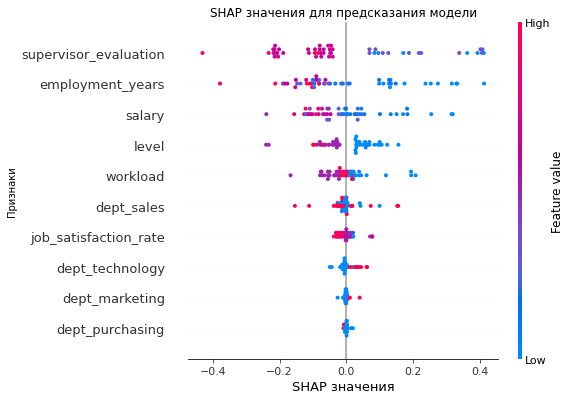

In [86]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_preprocessed_smpl, max_display=10, show=False)
plt.title('SHAP значения для предсказания модели')
plt.ylabel('Признаки')
plt.xlabel('SHAP значения')
plt.show()

**Самыми влиятельными признками оказались**:

1. Стаж в компании -- чем меньше стаж, тем выше вероятность ухода сотрудника
2. Оценка руководителя -- чем выше руководитель оценивает работу сотрудника (и наоборот), тем выше(ниже) вероятность ухода сотрудника.
3. Уровень компетенции -- junior-специалисты чаще всего уходят с работы
4. Низкая зарпалата увеличивает вероятность ухода сотрудника.
5. Удовлетворнность сотрудника -- чем недовольнее сотрудник, тем выше вероятность его ухода

### Применение модели на тесте <a id='4.6'>

In [87]:
# Сортируем таргет по индексам для предотвращения неверной оценки
df_add_target = df_add_target.sort_values(by='id').set_index('id')


In [88]:
# Закодируем таргет
y_test_true = encoder.fit_transform(df_add_target)
y_test_true

array([0, 0, 0, ..., 1, 0, 1])

In [89]:
# Предобработка данных через пайплайн без конечной модели
preprocessor = gs_2.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(df_features)

pred_test_2 = best_model.predict_proba(X_train_preprocessed)

In [90]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_true, pred_test_2[:,1])}')

Метрика ROC-AUC на тестовой выборке: 0.9153202107904147


### Итог задания № 2 <a id='4.7'>

<div  style="border-radius: 10px; border: 2px solid; padding: 40px ">
    
**Исследовательский анализ**:
    
* Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник или нет
   
* Составлен портрет уволившегося сотрудника:
    - Скорее всего работает в отделе продаж и технологий
    - Имеет низшую должность (junior)
    - Имеет низкую / среднюю загруженность
    - В среднем проработал 1-2 года в компании
    - В среднем зарабатывает до 30'000 
    - Оценка работодателя меньше 4
    
    
    
**Обучение модели**:

* Была проведена подготовка тренировочной и валидационной выборки. Также закодирован целевой признак методом _LabelEncoder_
    
* Создан единый пайплан, который содержит в себе масштабирование входных признаков и 4 модели.
    
* Использован подбор гиперпараметров _GridSearchCV_ 
    
* Лучшая модель -- **KNeighborsClassifier(n_neighbors=21)** с метрикой __ROC_AUC = 0.915__ на тестовой выборке
 
    
**Самыми влиятельными признками оказались**:

1. Стаж в компании -- чем меньше стаж, тем выше вероятность ухода сотрудника
2. Оценка руководителя -- чем выше руководитель оценивает работу сотрудника (и наоборот), тем выше(ниже) вероятность ухода сотрудника.
3. Уровень компетенции -- junior-специалисты чаще всего уходят с работы
4. Низкая зарпалата увеличивает вероятность ухода сотрудника.
5. Удовлетворнность сотрудника -- чем недовольнее сотрудник, тем выше вероятность его ухода

## Итоговый вывод <a id='8'>

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">


**1. Обучение модели**

В ходе работы была проведена подготовка данных, включая создание тренировочной и валидационной выборки, а также кодирование целевого признака с использованием метода _LabelEncoder_.

Создан единый пайплайн, который включает масштабирование входных признаков и использование нескольких моделей. Для подбора гиперпараметров применялся метод _GridSearchCV_.

**Результаты:**
- Лучшая модель из 1-й задачи: **SVR** с метрикой __smape = 13.96__ на тестовой выборке.
- Лучшая модель из 2-й задачи -- **KNeighborsClassifier(n_neighbors=21)** с метрикой __ROC_AUC = 0.915__ на тестовой выборке
    
    
**2. Анализ важности**

На основе выделенной лучшей модели был построен график важности признаков с использованием метода SHAP.

**Самыми влиятельными признаками оказались:**
- Оценка руководителя
- Зарплата
- Загруженность

**3. Исследовательский анализ**

Проведен анализ факторов, влияющих на увольнение сотрудников, что позволило сформировать портрет уволившегося сотрудника:
- Работает в отделе продаж или технологий
- Занимает низшую должность (junior)
- Имеет низкую или среднюю загруженность
- Проработал в компании 1-2 года
- Заработная плата до 30,000
- Оценка работодателя ниже 4

**4. Рекомендации по уменьшению увольнений сотрудников**

На основе проведенного анализа можно выделить несколько ключевых рекомендаций для уменьшения уровня увольнений:

1. **Улучшение оценки руководителей:** 
    
   - Провести тренинги для руководителей по эффективной оценке работы сотрудников и предоставлению конструктивной обратной связи.

    
2. **Пересмотр системы зарплат:**
    
   - Провести анализ рыночных зарплат и пересмотреть текущую систему оплаты труда для повышения конкурентоспособности.

    
3. **Увеличение вовлеченности сотрудников:**
    
   - Организовать командообразующие мероприятия и регулярные опросы для оценки удовлетворенности сотрудников.

    
4. **Поддержка карьерного роста:**
    
   - Внедрить четкие карьерные пути и возможности для обучения и развития, особенно для junior-специалистов.

    
5. **Мониторинг удовлетворенности сотрудников:**
    
   - Регулярно проводить опросы для оценки уровня удовлетворенности работой и выявления потенциальных проблем на ранних стадиях.

Эти меры помогут повысить удовлетворенность сотрудников, улучшить рабочую атмосферу и, как следствие, снизить уровень увольнений в компании.